In [ ]:
#@title Install required libraries

!pip install keras~=3.8.0 \
  matplotlib~=3.10.0 \
  pandas~=2.2.0 \
  tensorflow~=2.18.0
!pip uninstall numpy
!pip install numpy==1.26.4

^C
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    c:\users\doryd\anaconda3\lib\site-packages\numpy-1.26.4-cp312-cp312-win_amd64.whl
    c:\users\doryd\anaconda3\lib\site-packages\numpy-1.26.4.dist-info\*
    c:\users\doryd\anaconda3\lib\site-packages\numpy.libs\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-2bde3a66a51006b2b53eb373ff767a3f.dll
    c:\users\doryd\anaconda3\lib\site-packages\numpy\*
    c:\users\doryd\anaconda3\scripts\f2py.exe
Proceed (Y/n)? 


In [33]:
#general
import io


# data

import pandas as pd

# machine learning
import keras

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

In [40]:
chives = "https://chichives.com/csv/chives-data-public.csv" 
df = pd.read_csv(chives)

print(df.head())

         geoid  treeChng  treeCCov17  treeCCov10  HeathDeath_Percent  \
0  17031291600    -0.227       11.56   11.790699                3.27   
1  17031580200     0.152       13.51   13.359938                0.61   
2  17031590500    -2.953       23.67   26.621697                1.23   
3  17031590700     0.065        8.81    8.744273                1.23   
4  17031610400     0.695       12.05   11.352496                2.45   

   leadPoisonR      ndvi  trees_n  trees_crown_den  socvlnIndx  ...  \
0     2.457265  0.192543      453             11.8        63.9  ...   
1     1.559934  0.226763     1588             12.8        80.4  ...   
2     0.319489  0.405935     2093             27.8        80.7  ...   
3     0.319489  0.188116     1330              7.9        81.1  ...   
4     2.498216  0.210973      339              9.7        93.2  ...   

                      dsplcPresr  chwAirTemp  chwHeatAve  chwHeatMax  \
0      Vulnerable, Prices Rising   84.291567   88.925354   99.392030

In [47]:
#@title Code - Read dataset

# Updates dataframe to use specific columns.
training_df = df[['chwAirTemp','trees_n', 'ndvi', 'trees_crown_den', 'treeCCov10']]

print('Read dataset completed successfully.')
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.head(200)

Read dataset completed successfully.
Total number of rows: 801




,chwAirTemp,trees_n,ndvi,trees_crown_den,treeCCov10
0,84.291567,453,0.192543,11.8,11.790699
1,84.618429,1588,0.226763,12.8,13.359938
2,84.049685,2093,0.405935,27.8,26.621697
3,84.664682,1330,0.188116,7.9,8.744273
4,84.633101,339,0.210973,9.7,11.352496
...,...,...,...,...,...
195,84.914200,3150,0.287293,14.3,14.475939
196,84.627115,2233,0.273480,12.2,12.728967
197,84.358398,3683,0.327259,19.8,19.535158
198,84.843311,3144,0.332231,15.8,15.744585


In [48]:
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.describe(include='all')

Total number of rows: 801




,chwAirTemp,trees_n,ndvi,trees_crown_den,treeCCov10
count,801.000000,801.000000,798.000000,801.000000,801.000000
mean,83.866877,2135.905119,0.306624,19.180649,20.336646
std,0.963622,3244.690282,0.080967,7.995509,7.945002
min,79.128458,0.000000,0.072727,0.000000,0.689139
25%,83.603765,874.000000,0.252545,14.000000,14.941393
50%,84.133087,1452.000000,0.303582,18.800000,19.867359
75%,84.461832,2323.000000,0.359262,23.700000,25.092007
max,85.490008,58668.000000,0.657618,68.300000,67.997264


In [49]:
#@title Code - View correlation matrix
training_df.corr(numeric_only = True)

,chwAirTemp,trees_n,ndvi,trees_crown_den,treeCCov10
chwAirTemp,1.000000,-0.017693,-0.074465,-0.172356,-0.125744
trees_n,-0.017693,1.000000,0.410813,0.380770,0.310458
ndvi,-0.074465,0.410813,1.000000,0.766046,0.677192
trees_crown_den,-0.172356,0.380770,0.766046,1.000000,0.916024
treeCCov10,-0.125744,0.310458,0.677192,0.916024,1.000000


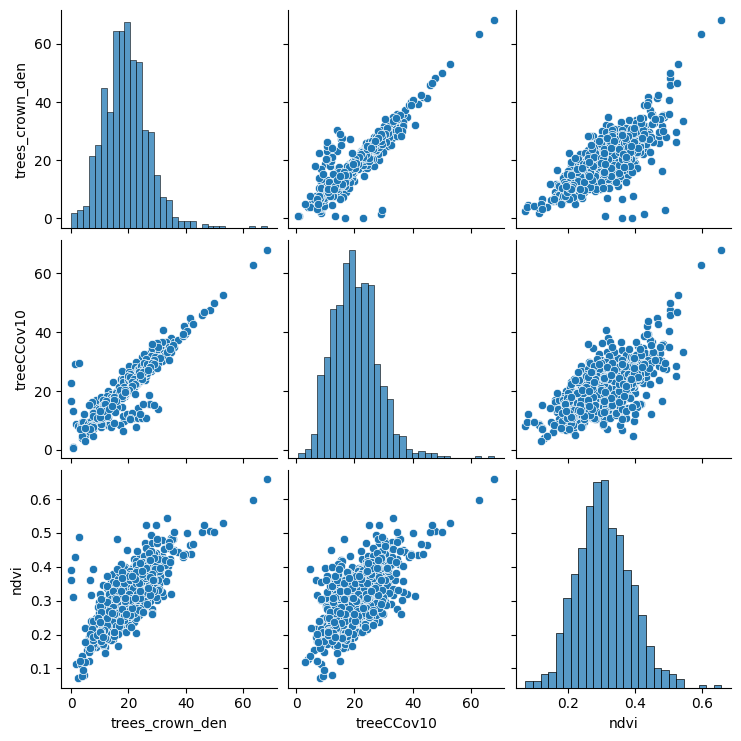

In [51]:
#@title Code - View pairplot
sns.pairplot(training_df, x_vars=['trees_crown_den', 'treeCCov10', 'ndvi'], y_vars=['trees_crown_den', 'treeCCov10', 'ndvi'])

def make_plots(df, feature_names, label_name, model_output, sample_size=200):

    random_sample = df.sample(n=sample_size).copy()
    random_sample.reset_index(drop=True, inplace=True)  # reset index properly
    weights, bias, epochs, rmse = model_output

    is_2d_plot = len(feature_names) == 1
    model_plot_type = "scatter" if is_2d_plot else "surface"
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=("Loss Curve", "Model Plot"),
                        specs=[[{"type": "scatter"}, {"type": model_plot_type}]])

    plot_data(random_sample, feature_names, label_name, fig)
    plot_model(random_sample, feature_names, weights, bias, fig)
    plot_loss_curve(epochs, rmse, fig)

    fig.show()
    return

def plot_loss_curve(epochs, rmse, fig):
    curve = px.line(x=epochs, y=rmse)
    curve.update_traces(line_color='#ff0000', line_width=3)

    fig.add_trace(curve.data[0], row=1, col=1)
    fig.update_xaxes(title_text="Epoch", row=1, col=1)
    fig.update_yaxes(title_text="Root Mean Squared Error", row=1, col=1, range=[rmse.min()*0.8, rmse.max()])

    return

def plot_data(df, features, label, fig):
    if len(features) == 1:
        scatter = px.scatter(df, x=features[0], y=label)
        fig.add_trace(scatter.data[0], row=1, col=2)
        fig.update_xaxes(title_text=features[0], row=1, col=2)
        fig.update_yaxes(title_text=label, row=1, col=2)
    else:
        scatter = px.scatter_3d(df, x=features[0], y=features[1], z=label)
        for trace in scatter.data:
            fig.add_trace(trace, row=1, col=2)
        fig.update_layout(scene=dict(
            xaxis_title=features[0],
            yaxis_title=features[1],
            zaxis_title=label
        ))

    return

def plot_model(df, features, weights, bias, fig):
    df['PREDICTED_AIRTEMP'] = bias[0]
    for idx, feature in enumerate(features):
        df['PREDICTED_AIRTEMP'] += weights[idx][0] * df[feature]

    if len(features) == 1:
        model_line = px.line(df.sort_values(by=features[0]), x=features[0], y='PREDICTED_AIRTEMP')
        model_line.update_traces(line_color='#ff0000', line_width=3)
        fig.add_trace(model_line.data[0], row=1, col=2)

    else:
        # Create a grid to plot the regression plane in 3D
        x_range = np.linspace(df[features[0]].min(), df[features[0]].max(), 10)
        y_range = np.linspace(df[features[1]].min(), df[features[1]].max(), 10)
        x_grid, y_grid = np.meshgrid(x_range, y_range)

        # Calculate corresponding z values from the regression equation: z = w1*x + w2*y + bias
        z_grid = weights[0][0] * x_grid + weights[1][0] * y_grid + bias[0]

        surface = go.Surface(
            x=x_grid, y=y_grid, z=z_grid,
            colorscale=[[0, '#89CFF0'], [1, '#FFDB58']],
            opacity=0.7,
            showscale=False
        )
        fig.add_trace(surface, row=1, col=2)

    return

def model_info(feature_names, label_name, model_output):
    weights = model_output[0]
    bias = model_output[1]

    nl = "\n"
    header = "-" * 80
    banner = header + nl + "|" + "MODEL INFO".center(78) + "|" + nl + header

    info = ""
    equation = label_name + " = "

    for index, feature in enumerate(feature_names):
        info += f"Weight for feature[{feature}]: {weights[index][0]:.3f}\n"
        equation += f"{weights[index][0]:.3f} * {feature} + "

    info += f"Bias: {bias[0]:.3f}\n"
    equation += f"{bias[0]:.3f}\n"

    return banner + nl + info + nl + equation

print("SUCCESS: defining plotting functions complete.")

In [62]:
#@title Code - Define ML functions

def build_model(my_learning_rate, num_features):
  """Create and compile a simple linear regression model."""
  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  inputs = keras.Input(shape=(num_features,))
  outputs = keras.layers.Dense(units=1)(inputs)
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model topography into code that Keras can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, features, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs.
  history = model.fit(x=features,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch.
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse


def run_experiment(df, feature_names, label_name, learning_rate, epochs, batch_size):

  print('INFO: starting training experiment with features={} and label={}\n'.format(feature_names, label_name))

  num_features = len(feature_names)

  features = df.loc[:, feature_names].values
  label = df[label_name].values

  model = build_model(learning_rate, num_features)
  model_output = train_model(model, features, label, epochs, batch_size)

  print('\nSUCCESS: training experiment complete\n')
  print('{}'.format(model_info(feature_names, label_name, model_output)))
  make_plots(df, feature_names, label_name, model_output)

  return model

print("SUCCESS: defining linear regression functions complete.")

SUCCESS: defining linear regression functions complete.


INFO: starting training experiment with features=['trees_crown_den'] and label=ndvi

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.4102 - root_mean_squared_error: 1.8458  
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1243 - root_mean_squared_error: 1.4564 
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3243 - root_mean_squared_error: 1.1498 
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7198 - root_mean_squared_error: 0.8475 
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3183 - root_mean_squared_error: 0.5635 
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1157 - root_mean_squared_error: 0.3386 
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - root_mean_squared_error: 0.1660 
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 - root_mean_squared_error: 0.1084 
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - root_mean_squared_error: 0.1025 
Epoch 10/20
16

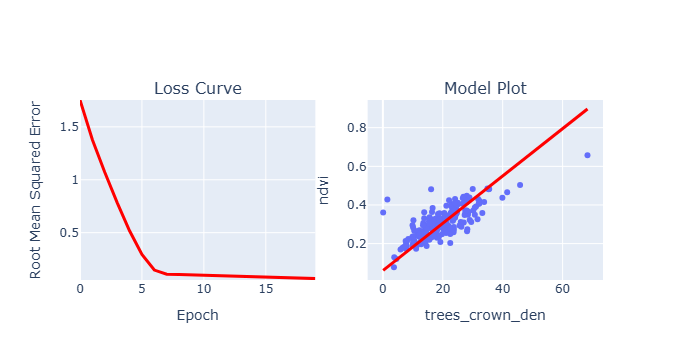

In [67]:
#@title Code - Experiment 1
import numpy as np
training_df = training_df.dropna(subset=features + [label])

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 50

# Specify the feature and the label.
features = ['trees_crown_den']
label = 'ndvi'  # Replace with actual column name you want to predict

model_1 = run_experiment(training_df, features, label, learning_rate, epochs, batch_size)